In [ ]:
!pip install lets-plot==4.1 polars==0.19 hdbscan==0.8.33 seaborn
import numpy as np
import polars as pl
import seaborn as sns
from lets_plot import *
LetsPlot.setup_html(isolated_frame=True)

# Analyse multivariée 1 : associations et partitionnements

À la fin de la section 4, nous avons couvert l'analyse de régression, qui en fait était une analyse statistique multivariée. Dans ce chapitre, nous verrons d'autres techniques d'exploration des données en mode multivarié.

Les données sont multivariées lorsqu'elles sont exprimées par plus d'une variable. Techniquement, une variable est un axe. C'est facile de visualiser un point sur un ou deux axes. C'est toujours possible avec 3. Mais, en tout cas pour les humains, cognitivement très difficile de voir des données en plus de 3 dimensions sans faire appel à sa capacité d'abstraction. Nous couvrirons les aspects multivariés suivants. Bien qu'il soit possible d'effectuer des tests statistiques sur leurs résultats, ce ne sont pas des stats, mais des techniques d'exploration (heuristiques).

1. Les **associations** permettent de quantifier la ressemblance ou la différence entre deux observation (échantillons) ou variables (descripteurs). Lorsque l'on a plus de deux variables ou plus de deux site, nous obtenons des matrices d'association.
2. Le **partitionnement** permet de regrouper des observations ou des variables selon des métriques d'association.

## Exploration graphique

La première étape d'une analyse multivariée est d'explorer les données. En outre, il se peut que les données comprennent des données manquantes ou aberrantes. Je vous réfère à la documentation du module scikit-learn pour l'[imputation](https://scikit-learn.org/stable/modules/impute.html) et la [détection d'oservations aberrantes](https://scikit-learn.org/stable/modules/outlier_detection.html).

On peut effectuer des explorations graphiques à l'aide de Semiotic, l'outil de création de Noteable.

Je vais encore utiliser les données sur les manchots, mais on pourrait tout autant effectuer les opérations de ce carnet de calcul sur des données de sols.

In [3]:
penguins = pl.read_csv("data/penguins.csv", null_values='NA')
penguins

rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
i64,str,str,f64,f64,i64,i64,str,i64
1,"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
2,"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007
3,"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007
4,"""Adelie""","""Torgersen""",null,null,null,null,null,2007
5,"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007
6,"""Adelie""","""Torgersen""",39.3,20.6,190,3650,"""male""",2007
7,"""Adelie""","""Torgersen""",38.9,17.8,181,3625,"""female""",2007
8,"""Adelie""","""Torgersen""",39.2,19.6,195,4675,"""male""",2007
9,"""Adelie""","""Torgersen""",34.1,18.1,193,3475,null,2007


Une bonne manière d'explorer les données multivariées est le diagramme pairé. Puisque ce type de diagramme n'est en ce moment disponible ni sur Semiotic, ni sur Lets-plot, nous utilisons le module graphique [*Seaborn*](seaborn.pydata.org). 

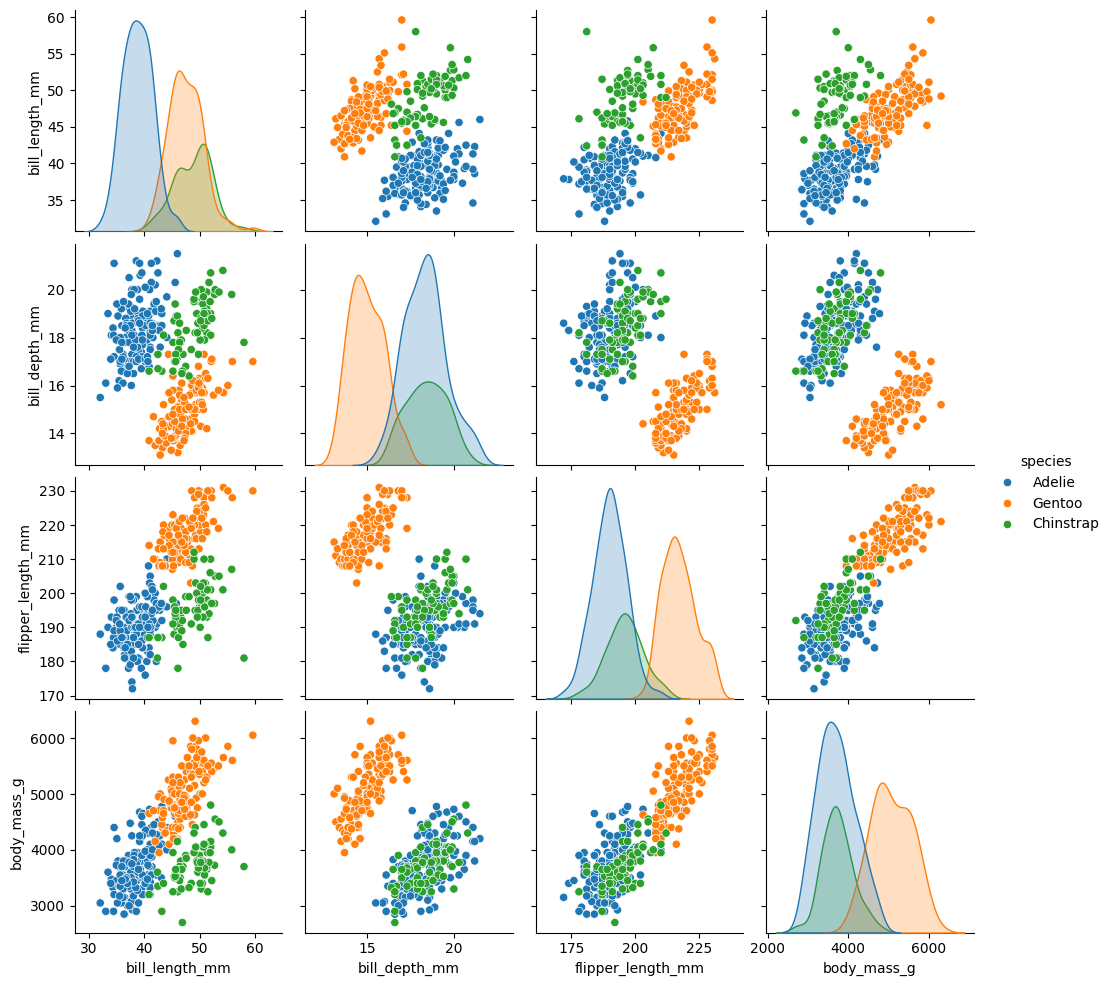

In [4]:
sns.pairplot(
    penguins.to_pandas(), 
    vars = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], 
    hue = 'species',
    diag_kind = 'kde'
);

- Est-ce qu'une seule variable est apte à discriminer les trois espèces ? Sinon, quelles variables sélectionnerez-vous pour identifier l'espèce avec un point dans l'espace multivarié ?
- Quelles variables sont corrélées, lesquelles le sont moins ?
- Les distributions sont-elles normales ? Qu'est-ce qui pourrait faire en sorte que les distributions contiennent des bosses ?

## Ressemblance, dissemblance et association

Nous utiliserons le terme *association* comme une **mesure pour quantifier la ressemblance ou la différence entre deux objets (échantillons) ou variables (descripteurs)**.

Alors que la corrélation et la covariance sont des mesures d'association entre des variables (analyse en *mode R*), la **similarité** et la **distance** sont deux types de une mesure d'association entre des objets (analyse en *mode Q*). Une distance de 0 est mesurée chez deux objets identiques. La distance augmente au fur et à mesure que les objets sont dissociés. Une similarité ayant une valeur de 0 indique aucune association, tandis qu'une valeur de 1 indique une association parfaite. À l'opposé, la dissimilarité est égale à 1-similarité.

La distance peut être liée à la similarité par la relation:

$$distance=\sqrt{1-similarité}$$

ou

$$distance=\sqrt{dissimilarité}$$

La racine carrée permet, pour certains indices de similarité, d'obtenir des propriétés euclédiennes. Pour plus de détails, voyez le tableau 7.2 de [Legendre et Legendre (2012)](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0).

Les matrices d'association sont généralement présentées comme des matrices carrées, dont les dimensions sont égales au nombre d'objets (*mode Q*) ou de variables (*mode R*) dans le tableau. Chaque élément ("cellule") de la matrice est un indice d'association entre un objet (ou une variable) et un autre. Ainsi, la diagonale de la matrice est un vecteur nul (distance ou dissimilarité) ou unitaire (similarité), car elle correspond à l'association entre un objet et lui-même. 

Puisque l'association entre A et B est la même qu'entre B et A, et puisque la diagonale retourne une valeur convenue, il est possible d'exprimer une matrice d'association en mode "compact", sous forme de vecteur. Le vecteur d'association entre des objets A, B et C contiendra toute l'information nécessaire en un vecteur de trois chiffres, `[AB, AC, BC]`, plutôt qu'une matrice de dimension 3 × 3. L'impact sur la mémoire vive peut être considérable pour les calculs comprenant de nombreuses dimensions.

En Python, les calculs de similarité et de distances peuvent être effectués avec le module *Scipy*. La fonction `squareform()` permet d'extraire un vecteur de distance et d'afficher des matrices carrées.

En géotechnique, une étude sur les associations pourrait permettre, par exemple, de voir quels échantillons de sols sont plus semblables ou inversement plus différents.

Il existe plusieurs métriques de distance. Par exemple, la distance de Gower peut considérer différents types de variables, alors que des distances euclidiennes ne peuvent considérer que les variables numériques. Nous nous arrêterons aux distances euclidienne et de Mahalanobis.

### La distance euclidienne

La distance euclidienne entre deux vecteurs est calculée avec la formule de Pythagore.

$$
d(\vec{x},\vec{y}) = \sqrt{(\vec{x}-\vec{y})^2}
$$

Pour éviter de surcharger les graphiques, prenons 10 manchots au hasard. 

In [5]:
penguins_sample = penguins.sample(10, seed=6270574)
penguins_sample = (
    penguins_sample
    .with_columns(
        pl.concat_str([pl.col('rowid'), pl.col('species'), pl.col('sex')], separator=' ').alias('sample_id')
    )
)

Je calcule la distance euclidienne, puis je présence le graphique, toujours avec *Seaborn*.

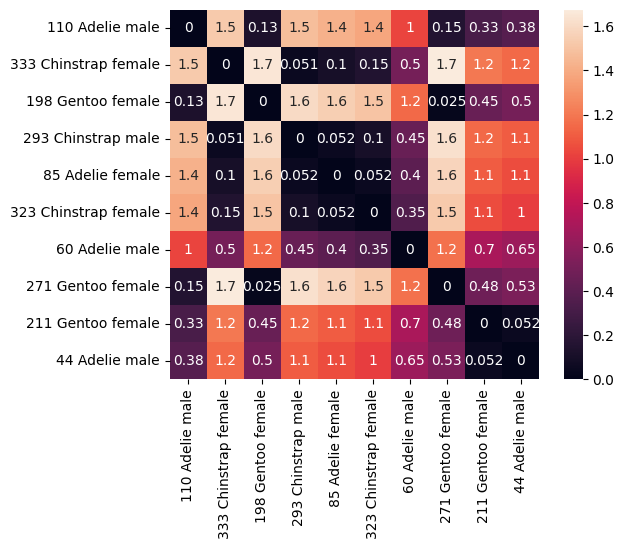

In [6]:
from scipy.spatial.distance import pdist, squareform

penguin_attributes = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
penguins_num = penguins_sample.select(penguin_attributes)
eucl_distances = pdist(penguins_num, metric='euclidean')
eucl_dist_matrix = squareform(eucl_distances)
eucl_dist_df = pl.DataFrame(eucl_dist_matrix/1000) # /1000 pour pouvoir bien voir les chiffres
eucl_hm = sns.heatmap(eucl_dist_df, annot=True, square=True)
eucl_hm.set_xticklabels(penguins_sample['sample_id'].to_list(), rotation=90)
eucl_hm.set_yticklabels(penguins_sample['sample_id'].to_list(), rotation=0);

- Quels individus sont les plus proches ? Les plus éloignés ?
- Si je vous disais que la distance euclidienne n'est pas fiable dans ce cas, avez-vous une idée pourquoi ?

Parce que la distance euclidienne dépend des unités utilisées. Elle prendrait une autre forme si la masse avait été calculée en kg, par exemple. Une solution pour uniformiser les variables est de soustraire la moyenne et diviser par l'écart-type. On pourrait le faire. Mais tant qu'à y être, on pourrait aussi considérer la corrélation avec la distance de Mahalanobis.

### La distance de Mahalanobis

La distance de Mahalanobis est semblable à la distance euclidienne, mais elle tient compte de la covariance de la matrice des objets. Cette covariance peut être utilisée pour décrire la structure d'un nuage de points. La figure suivante montre deux points verts qui se trouvent aux extrêmes d'un nuage de point. Ces points ont des distances euclidiennes différentes par rapport au centre : les lignes d'équidistance euclidienne sont tracées en rose. Toutefois, les deux points ont un3 distance de Mahalanobis égale à partir du centre.

![](images/mahalanobis.png)

L'équation est semblable à celle de la distance euclidienne:

$$
d_M(\vec{x} ,\vec{y}; Q) = \sqrt{(\vec{x} - \vec{y})^\mathsf{T} S^{-1} (\vec{x} - \vec{y})}
$$

Attention ici, il se pourrait que l'inversion de la matrice de corrélation soit singulière. Dans ce cas, [des méthodes d'approximation existent](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) !

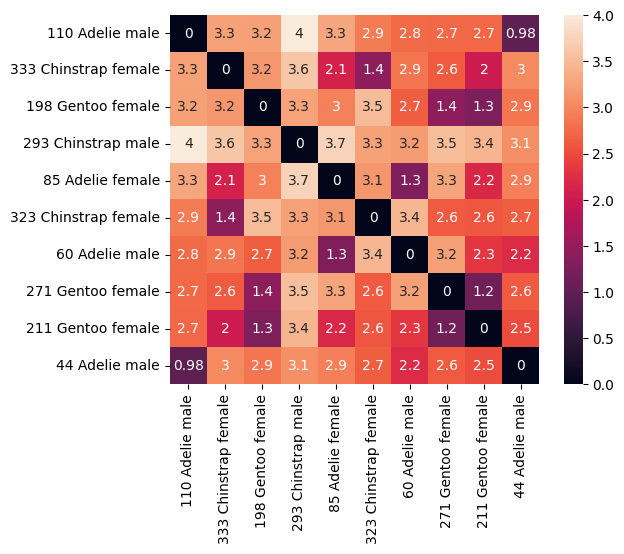

In [7]:
maha_distances = pdist(penguins_num, metric='mahalanobis')
maha_dist_matrix = squareform(maha_distances)
maha_dist_df = pl.DataFrame(maha_dist_matrix)
maha_hm = sns.heatmap(maha_dist_df, annot=True, square=True)
maha_hm.set_xticklabels(penguins_sample['sample_id'].to_list(), rotation=90)
maha_hm.set_yticklabels(penguins_sample['sample_id'].to_list(), rotation=0);

- Quels individus sont les plus proches? Les plus éloignés?
- Comment pourrait-on inclure le sexe dans le calcul de la distance ?

Il existe de nombreuses manières de calculer des distances. Les résultats d'une étude sur les distances sont intimement liés à la métrique utilisée.

Les distances peuvent être utiles pour assigner des catégories à des observations qui *a piori* n'en ont pas.

## Partitionnement

Les données suivantes ont été générées par [Leland McInnes](https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy) (Tutte institute of mathematics, Ottawa). Êtes-vous en mesure d'identifier des groupes ? Combien en trouvez-vous ?

In [8]:
df_mcinnes = pl.read_csv('data/clusterable_data.csv')
(
    ggplot(df_mcinnes, aes(x='X', y='Y'))
    + geom_point()
)

En 2D, l'oeil humain peut facilement détecter les groupes. En 3D, c'est toujours possible, mais au-delà de 3D, le partitionnement cognitive devient rapidement maladroite. Les algorithmes sont alors d'une aide précieuse. Mais, ils transportent en pratique tout un bagage de limitations. Quel est le critère d'association entre les groupes ? Combien de groupe devrions-nous créer ? Comment distinguer une donnée trop bruitée pour être classifiée ?

Le partitionnement de données (clustering en anglais), et inversement leur regroupement, permet de créer des ensembles selon des critères d'association. On suppose donc que Le partitionnement permet d'attribuer des groupes selon l'information que l'on fait émerger des données. Il est conséquemment entendu que les données ne sont pas catégorisées *a priori* : il ne s'agit pas de prédire la catégorie d'un objet, mais bien de créer des catégories à partir des objets, par exemple selon leurs dimensions, leurs couleurs, leur signature chimique, leurs comportements, leurs gènes, etc.

Plusieurs méthodes sont aujourd'hui offertes aux analystes pour partitionner leurs données. Nous couvrirons ici deux grandes tendances dans les algorithmes.

- **Méthodes hiérarchiques et non hiérarchiques**. Dans un partitionnement hiérarchique, l'ensemble des objets forme un groupe, comprenant des sous-regroupements, des sous-sous-regroupements, etc., dont les objets forment l'ultime partitionnement. À l'inverse, le partitionnement non hiérarchique est... non hiérarchique...

- **Membership exclusif ou flou**. Certaines techniques attribuent aux observations une classe exclusive : le jugement d'appartenance à une classe est binaire. D'autres techniques vont attribuer un membership flou où le degré d'appartenance est une variable continue de 0 à 1.

Nous n'explorerons pas le membership flou, mais couvrirons des méthodes hiérarchiques et non hiérarchiques.

### Partitionnement non hiérarchique

Il peut arriver que vous n'ayez pas besoin de comprendre la structure d'agglomération des objets (ou variables).  Plusieurs techniques de partitionnement non hiérarchique [sont disponibles dans le module *Scikit-Learn*](http://scikit-learn.org/stable/modules/clustering.html) (*Scikit-Learn* est un couteau suisse pour la modélisation empirique en Python). On s'intéressera en particulier à celles-ci.

#### Kmeans (`sklearn.cluster.Kmeans`)

L'objectif des kmeans est de minimiser la distance euclidienne entre un nombre prédéfini de *k* groupes exclusifs.

1. L'algorithme commence par placer un nombre *k* de centroïdes au hasard dans l'espace d'un nombre *p* de variables (vous devez fixer *k*, et *p* est le nombre de colonnes de vos données).
2. Ensuite, chaque objet est étiqueté comme appartenant au groupe du centroïde le plus près.
3. La position du centroïde est déplacée à la moyenne de chaque groupe.
4. Recommencer à partir de l'étape 2 jusqu'à ce que l'assignation des objets aux groupes ne change plus.

![](https://media.giphy.com/media/12vVAGkaqHUqCQ/giphy.gif)
Source: [David Sheehan](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

La technique des kmeans suppose que les groupes ont des distributions multinormales - représentées par des cercles en 2D, des sphères en 3D, des hypersphères en plus de 3D. Cette limitation est problématique lorsque les groupes se présentent sous des formes irrégulières, comme celles du nuage de points de Leland McInnes, présenté plus haut. De plus, la technique classique des kmeans est basée sur des distances euclidiennes: l'utilisation des kmeans n'est appropriée pour les données comprenant beaucoup de zéros, comme les données d'abondance, qui devraient préalablement être transformées en variables centrées et réduites ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0)). La technique des **mixtures gaussiennes** (*gaussian mixtures*, `sklearn.mixture.GaussianMixture`) est une généralisation des kmeans permettant d'intégrer la covariance des groupes. Les groupes ne sont plus des hyper-sphères, mais des hyper-ellipsoïdes.



##### Application

Dans *Scikit-Learn*, on définit d'abord le modèle (par exemple `Kmeans(...)`), puis on l'applique à nos données (`fit(...)`). Enfin on applique le modèle sur des données (`predict(...)`). Certaines fonctions utilisent toutefois le raccourci `fit_predict()`. Chaque algorithme doit être ajusté avec les paramètres qui convient. De nombreux paramètres par défaut sont utilisés dans les exécutions ci-dessous. Lors de travaux de recherche, l'utilisation d'un argument ou d'un autre dans une fonction doit être justifié : qu'un paramètre soit utilisé par défaut dans une fonction n'est a priori pas une justification convaincante.

Nous allons classifier les données de Leland McInnes, présentée ci-dessus. Importons les fonctions nécessaires.

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics

Pour les *kmeans*, on doit fixer le nombre de groupes. Le graphique des données de Leland McInnes montrent 6 groupes. Toutefois, il est rare que l'on puisse visualiser de telles démarcations, qui plus est dans des cas où l'on doit traiter de plus de deux dimensions. Je vais donc lancer le partitionnement en boucle pour plusieurs nombres de groupes, de 3 à 10 et pour chaque groupe, évaluer le score silhouette et de Calinski-Habaraz. J'utilise un argument `random_state` pour m'assurer que les groupes seront les mêmes à chaque fois que la cellule sera lancée.

In [10]:
silouhette_score = []
calinski_index = []
n_groups = list(range(3, 10))
for i in n_groups:
    mcinnes_kmeans_labels = (
        KMeans(n_clusters=i, random_state=5437925)
        .fit_predict(df_mcinnes.select(['X', 'Y']))
    )
    silouhette_score.append(
        metrics
        .silhouette_score(df_mcinnes.select(['X', 'Y']), mcinnes_kmeans_labels, metric='euclidean')
    )
    calinski_index.append(
        metrics
        .calinski_harabasz_score(df_mcinnes.select(['X', 'Y']), mcinnes_kmeans_labels)
    )

/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

In [11]:
kmeans_scores = pl.DataFrame({
    'Number of groups': n_groups,
    'silouhette_score': silouhette_score,
    'calinski_index': calinski_index
}).melt(id_vars = 'Number of groups')

(
    ggplot(kmeans_scores, aes(x='Number of groups', y='value'))
    + geom_point()
    + geom_line()
    + facet_wrap(facets='variable', scales='free', ncol=2)
)

Considérant les deux scores, 6 groupes semble visuellement correspondre à un optimal. Ajoutons une colonne étiquetant le groupe au tableau `df_mcinnes`.

In [12]:
df_mcinnes = (
    df_mcinnes
    .with_columns((
        pl.Series(KMeans(n_clusters=6, random_state=5437925).fit_predict(df_mcinnes)
    )).alias('Kmeans_6groups'))
)

(
    df_mcinnes
    .groupby('Kmeans_6groups')
    .count()
)

/Users/essi/mambaforge/envs/dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/7p/wk_02tlx73db7yv0wvbxc1jh0000gn/T/ipykernel_94129/1876372286.py:10: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby('Kmeans_6groups')


Kmeans_6groups,count
i32,u32
0,478
5,271
2,387
1,354
4,489
3,330


#### DBSCAN (`sklearn.cluster.DBSCAN`)

La technique DBSCAN (* **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise*) sousentend que les groupes sont composés de zones où l'on retrouve plus de points (zones denses) séparées par des zones de faible densité. Pour lancer l'algorithme, nous devons spécifier une mesure d'association critique (distance ou dissimilarité) *d* ainsi qu'un nombre de points critique *k* dans le voisinage de cette distance.

1. L'algorithme étiquette chaque point selon l'une de ces catégories:

    - *Noyau*: le point a au moins *k* points dans son voisinage, c'est-à-dire à une distance inférieure ou égale à *d*.
    - *Bordure*: le point a moins de *k* points dans son voisinage, mais l'un de des points voisins est un *noyau*.
    - *Bruit*: le cas échéant. Ces points sont considérés comme des outliers.

![](images/dbscan_1.png)

2. Les noyaux distancés de *d* ou moins sont connectés entre eux en englobant les bordures.

![](images/dbscan_2.png)

Le nombre de groupes est prescrit par l'algorithme DBSCAN, qui permet du coup de détecter des données trop bruitées pour être classées.

##### Application

La technique **DBSCAN** n'est pas basée sur le nombre de groupe, mais sur la densité des points. Il est possible de spécifier le type d'association à utiliser dans l'argument `metric`, mais dans ce cas on doit se limiter aux [métriques offertes par scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) (qui sont celles de *Scipy*). Si la métrique souhaitée n'est pas disponible parmi celles-là, la matrice d'association peut être spécifiée dans l'argument `X` plutôt que les données directes quand l'argument `metric` est égal à `"precomputed"`. L'argument `min_samples` spécifie le nombre minimal de points qui l'on doit retrouver à une distance critique *d* pour la formation des *noyaux* et la propagation des groupes, spécifiée dans l'argument `eps`. La distance *d* peut être estimée en prenant une fraction de la moyenne, mais on aura volontiers recours à son bon jugement.

In [13]:
from sklearn.cluster import DBSCAN
mcinnes_dbscan_distmat = squareform(pdist(df_mcinnes.select(['X', 'Y']), 'mahalanobis'))
mcinnes_dbscan = DBSCAN(metric='precomputed', min_samples=50, eps=0.23)

df_mcinnes = (
    df_mcinnes
    .with_columns((
        pl.Series(mcinnes_dbscan.fit_predict(mcinnes_dbscan_distmat))
    ).alias('DBSCAN_groups'))
)

(
    df_mcinnes
    .groupby('DBSCAN_groups')
    .count()
)

/var/folders/7p/wk_02tlx73db7yv0wvbxc1jh0000gn/T/ipykernel_94129/2577364726.py:14: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby('DBSCAN_groups')


DBSCAN_groups,count
i64,u32
0,806
2,188
1,201
4,317
3,258
-1,539


In [14]:
df_mcinnes_tidy = (
    df_mcinnes
    .melt(id_vars=['X', 'Y'])
    .with_columns(pl.col('value').cast(pl.Utf8).cast(pl.Categorical))
)

(
    ggplot(data=df_mcinnes_tidy)
    + geom_point(mapping = aes(x = 'X', y = 'Y', color = 'value'))
    + facet_wrap(facets='variable', ncol=2)
)

L'algorithme *kmeans* est loin d'être satisfaisant. Cela est attendu, puisque les *kmeans* recherchent des distributions gaussiennes sur des groupes vraisemblablement non gaussiens. *DBSCAN* ne fait qu'un peu mieux. Néanmoins, *DBSCAN* sait rejeter plusieurs points (étiquettés `-1`), que *kmeans* tente de classifier.

### Partitionnement hiérarchique

Les techniques de partitionnement hiérarchique sont basées sur les matrices d'association. La technique pour mesurer l'association (entre objets ou variables) déterminera en grande partie le partitionnement des données. Les partitionnements hiérarchiques ont l'avantage de pouvoir être représentés sous forme de dendrogramme (ou arbre) de partitions. Un tel dendrogramme présente des sous-groupes qui se joignent séquentiellement en groupes jusqu'à former un seul ensemble. Ou, inversement, un seul groupe qui se fragmente séquentiellement jusqu'à ce que chaque observation constitue elle-même un groupe.

Le partitionnement hiérarchique est abondamment utilisé en phylogénie, pour étudier les relations de parenté entre organismes vivants, populations d'organismes et espèces.

#### Techniques de partitionnement hiérarchique

Le partitionnement hiérarchique est typiquement effectué avec une des quatres méthodes suivantes, dont chacune possède ses particularités, mais sont toutes agglomératives: à chaque étape d'agglomération, on fusionne les deux groupes ayant le plus d'affinité sur la base des deux sous-groupes les plus rapprochés.

**Single link** (`single`). Les groupes sont agglomérés sur la base des deux points parmi les groupes, qui sont les plus proches.

**Complete link** (`complete`). À la différence de la méthode *single*, on considère comme critère d'agglomération les éléments les plus éloignés de chaque groupe.

**Agglomération centrale**. Il s'agit d'une fammille de méthode basées sur les différences entre les tendances centrales des objets ou des groupes.

- **Average** (`average`). Appelée UPGMA (Unweighted Pair-Group Method unsing Average), les groupes sont agglomérés selon un centre calculés par la moyenne et le nombre d'objet pondère l'agglomération (le poids des groupes est retiré). Cette technique est historiquement utilisée en bioinformatique pour partitionner des groupes phylogénétiques ([Sneath et Sokal, 1973](https://www.cabdirect.org/cabdirect/abstract/19730310919)).
- **Weighted** (`weighted`). La version de average, mais non pondérée (WPGMA).
- **Centroid** (`centroid`). Tout comme average, mais le centroïde (centre géométrique) est utilisé au lieu de la moyenne. Accronyme: UPGMC.
- **Median** (`median`). Appelée WPGMC. Devinez! ;)

**Ward** (`ward`). L'optimisation vise à minimiser les sommes des carrés par regroupement.

#### Quel outil de partitionnement hiérarchique utiliser?

Alors que le choix de la matrice d'association dépend des données et de leur contexte, la technique de partitionnement hiérarchique peut, quant à elle, être basée sur un critère numérique. Il en existe plusieurs, mais le critère recommandé pour le choix d'une technique de partitionnement hiérarchique est la **corrélation cophénétique**. La distance cophénétique est la distance à laquelle deux objets ou deux sous-groupes deviennent membres d'un même groupe. La corrélation cophénétique est la corrélation de Pearson entre le vecteur d'association des objets et le vecteur de distances cophénétiques.

#### Application

Les techniques de partitionnement hiérarchique présentées ci-dessus, ainsi que la fonction `cophenet` pour calculer la corrélation cophénétique, sont disponibles dans `scipy.cluster.hierarchy`. Nous allons classifier les données de McInnes grâce à la distance de Mahalabonis.

In [15]:
from scipy.cluster.hierarchy import *

mcinnes_hclust_distmat = pdist(df_mcinnes.select(['X', 'Y']), 'mahalanobis')

clustering_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
clust_l = []
coph_corr_l = []
for i in range(len(clustering_methods)):
    clust_m = linkage(y=mcinnes_hclust_distmat, method=clustering_methods[i])
    clust_l.append(clust_m)
    coph_corr_l.append(cophenet(clust_m, mcinnes_hclust_distmat)[0])

# créer un dictionnaire avec les listes
clust_d = dict(zip(clustering_methods, clust_l))
coph_corr_d = dict(zip(clustering_methods, coph_corr_l))

# créer un tableau grâce au dictionnaire
coph_corr_df = (
    pl.DataFrame(coph_corr_d)
    .melt()
    .with_columns(pl.col('value').round(2).cast(pl.Utf8).alias('label'))
)

# graphique
(
    ggplot(coph_corr_df, aes(x='value', y='variable'))
    + geom_vline(xintercept=0)
    + geom_lollipop(orientation='y', size=7)
    + geom_text(aes(label='label'), hjust='center', vjust='center')
)


La méthode `average` retourne la corrélation la plus élevée. Pour plus de flexibilité, enchâssons le nom de la méthode dans une variable. Ainsi, en changeant le nom de cette variable, le reste du code sera conséquent.

In [16]:
best_method = 'average'

Le partitionnement hiérarchique peut être visualisé par un dendrogramme avec le module graphique *Matplotlib*.

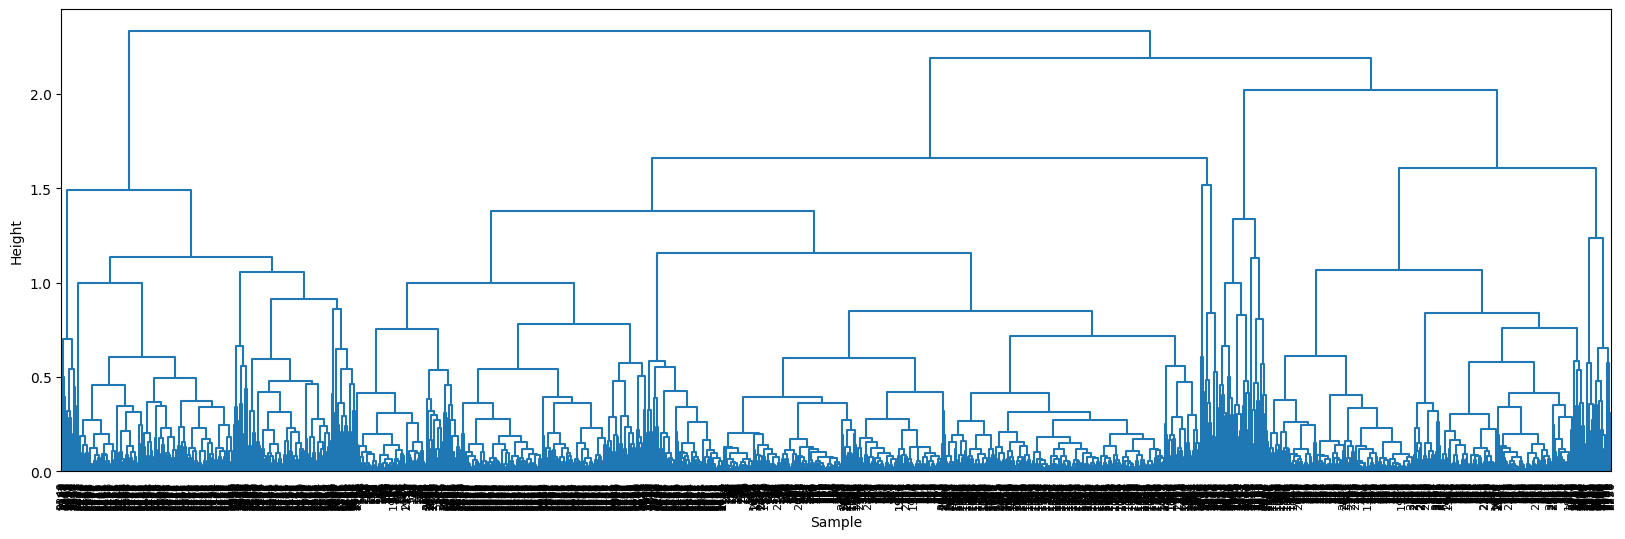

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
dnd = dendrogram(clust_d[best_method], color_threshold=0, leaf_font_size=8)
plt.xlabel('Sample')
plt.ylabel('Height');

#### Combien de groupes utiliser ?

La longueur des lignes verticales est la distance séparant les groupes enfants. Bien que la sélection du nombre de groupes soit avant tout basée sur les besoins du problème, nous pouvons nous appuyer sur certains outils. La hauteur totale peut servir de critère pour définir un nombre de groupes adéquat. On pourra sélectionner le nombre de groupes où la hauteur se stabilise en fonction du nombre de groupes. On pourra aussi utiliser le *graphique silhouette*, comprenant une collection de *largeurs de silouhette*, représentant le degré d'appartenance à son groupe. La fonction `sklearn.metrics.silhouette_score`, du module scikit-learn, s'en occupe.


In [20]:
silouhette = []
max_clus = 20
n_clust = list(range(3, max_clus))
for i in n_clust:
    nodes_f = fcluster(Z=clust_d[best_method], t=i, criterion='maxclust')
    silouhette.append(metrics.silhouette_score(df_mcinnes.select(['X', 'Y']), nodes_f, metric='euclidean'))

silouhette_scores_df = (
    pl.DataFrame({
        'Number of clusters': n_clust,
        'score': silouhette
    })
    .with_columns(pl.Series(np.repeat('Silouhette', len(n_clust))).alias('variable'))
)

(
    ggplot(silouhette_scores_df, aes(x='Number of clusters', y='score'))
    + geom_point()
    + geom_line()
)

Le maximum est atteint à 2 groupes, mais on peut se permettre d'en avoir davantage, disons 9. L'algorithme de la fonction `dendrogram()` demande non pas le nombre de groupes, mais la hauteur à laquelle trancher sur l'axe des y. Pour retrouver la hauteur à laquelle couper pour obtenir 12 groupes, on peut tester plusieurs hauteurs, calculer le nombre de groupes, puis extraire la hauteur que l'on recherche.

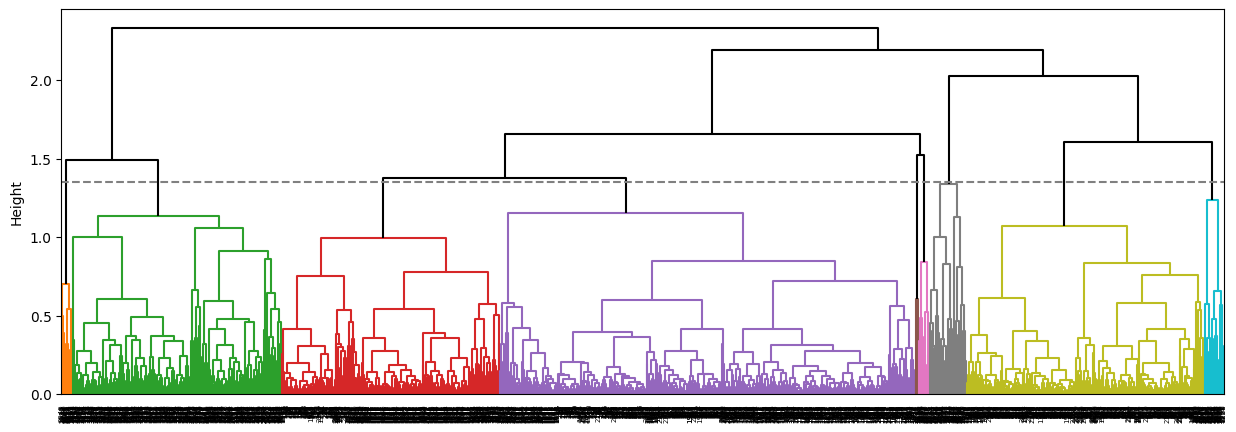

In [21]:
number_of_groups_hclust = 9
heights_test = np.logspace(-0.5, 0.5, 100)
n_groups = []
for h in heights_test:
    nodes_f = fcluster(Z=clust_d[best_method], t=h, criterion='distance')
    n_groups.append(len(np.unique(nodes_f)))
    
cut_off = heights_test[np.array(n_groups) == number_of_groups_hclust].mean()
plt.figure(figsize=(15, 5))
dendrogram(
    clust_d[best_method],
    leaf_rotation=90,
    color_threshold=cut_off,
    above_threshold_color='black'
)
plt.axhline(y=cut_off, c='grey', linestyle='dashed')
plt.ylabel('Height');

Intégrons les résultats à notre tableau.

In [22]:
df_mcinnes = (
    df_mcinnes
    .with_columns(
        pl.Series(fcluster(Z=clust_d[best_method], t=number_of_groups_hclust, criterion='maxclust'))
        .alias('hclust_groups')
    )
)

### Partitionnement hiérarchique basée sur la densité des points
La tecchinque HDBSCAN, dont l'algorithme est relativement récent ([Campello et al., 2013](https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14)), permet une partitionnement hiérarchique sur le même principe des zones de densité de la technique DBSCAN. Le HDBSCAN a été utilisée pour partitionner les lieux d'escale d'oiseaux migrateurs en Chine ([Xu et al., 2013](https://www.jstage.jst.go.jp/article/dsj/12/0/12_WDS-027/_article)).

Avec *DBSCAN*, un rayon est fixé dans une métrique appropriée. Pour chaque point, on compte le nombre de points voisins, c'est-à-dire le nombre de points se situant à une distance (ou une dissimilarité) égale ou inférieure au rayon fixé. Avec *HDBSCAN*, on spécifie le nombre de points devant être recouverts et l'on calcule le rayon nécessaire pour les recouvrir. Ainsi, chaque point est associé à un rayon critique que l'on nommera d<sub>noyau</sub>. La métrique initiale est ensuite altérée : on remplace les associations entre deux objets A et B par la valeur maximale entre cette association, le rayon critique de A et le rayon critique de B. Cette nouvelle distance est appelée la *distance d'atteinte mutuelle* : elle accentue les distances pour les points se trouvant dans des zones peu denses. On applique par la suite un algorithme semblable à la partition hiérarchique *single link* : En s'élargissant, les rayons se superposent, chaque superposition de rayon forment graduellement des groupes qui s'agglomèrent ainsi de manière hiérarchique. Au lieu d'effectuer une tranche à une hauteur donnée dans un dendrogramme de partitionnement, la technique *HDBSCAN* se base sur un dendrogramme condensé qui écarte les sous-groupes comprenant moins de *n* objets (n<sub>grmin</sub>). Dans nouveau dendrogramme, on recherche des groupes qui occupent bien l'espace d'analyse. Pour ce faire, on utilise l'inverse de la distance pour créer un indicateur de *persistance* (semblable à la similarité), λ. Pour chaque groupe hiérarchique dans le dendrogramme condensé, on peut calculer la persistance duquel le groupe prend naissance. De plus, pour chaque objet d'un groupe, on peut aussi calculer une distance à laquelle il quitte le groupe. La *stabilité* d'un groupe est la somme des différences de persistance entre la persistance à la naissance et les persistances des objets. On descend dans le dendrogramme. Si la somme des stabilités des groupes enfants est plus grande que la stabilité du groupe parent, on accepte la division. Sinon, le parent forme le groupe. La [documentation du module `hdbscan`](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) pour Python offre une description intuitive et plus exhaustive des principes et algorithme de *HDBSCAN*.

#### Paramètres

Outre la métrique d'association dont nous avons discuté, HDBSCAN demande d'être nourri avec [quelques paramètres importants](http://hdbscan.readthedocs.io/en/latest/parameter_selection.html). En particulier, le **nombre minimum d'objets par groupe**, n<sub>grmin</sub> (ou `min_cluster_size` dans le module `hdbscan`) dépend de la quantité de données que vous avez à votre disposition, ainsi que de la quantité d'objets que vous jugez suffisante pour créer des groupes. Ce paramètre a évedemment une influence sur le nombre de groupes formés, mais aussi sur la quantité de valeurs aberrantes détectées. Un autre paramètre important est le **nombre de points devant être recouverts**, k (`min_samples` dans `hdbscan`). Plus k est élevé, plus la densité nécessaire pour créer un groupe sera élevée et plus HDBSCAN désignera de points somme du bruit. Parmi les **algorithmes de sélection des groupes** du module `hdbscan`, on retrouve l'*excess of mass* (`cluster_selection_method='eom'`, par défaut) qui a tendance à créer des groupes de tailles différentes, et *leaf* (`cluster_selection_method='leaf'`) qui permet de créer des groupes comprenant des quantités d'objets plus homogènes.

#### Application

Utilisons le module `hdbscan` ainsi que les données de Leland McInnes. La métrique utilisée sera la distance de Mahalanobis. Les métriques disponibles sont [celles de scikit-learn](http://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html). Il est néamoins possible d'utiliser une métrique personalisée (Gower, par exemple) en utilisant la matrice d'association en guise de données et en spécifiant `metric='precomputed'`.

In [23]:
import hdbscan

cov_mcinnes = np.cov(df_mcinnes.select(['X', 'Y']).to_numpy().T) # pour utiliser la dist. de Mahalanobis

hdbscan_clust = hdbscan.HDBSCAN(
    min_cluster_size=20, # le nombre de point minimum par groupe
    min_samples=5, # le nombre de points dans le voisinage pour calculer le "rayon noyau"
    metric='mahalanobis',
    V = cov_mcinnes,
    gen_min_span_tree=True
)
hdbscan_clust.fit(df_mcinnes.select(['X', 'Y']))

HDBSCAN(gen_min_span_tree=True, metric='mahalanobis', min_cluster_size=20,
        min_samples=5)

On peut ainsi créer un dendrogramme où les ellipses représentent les groupes.

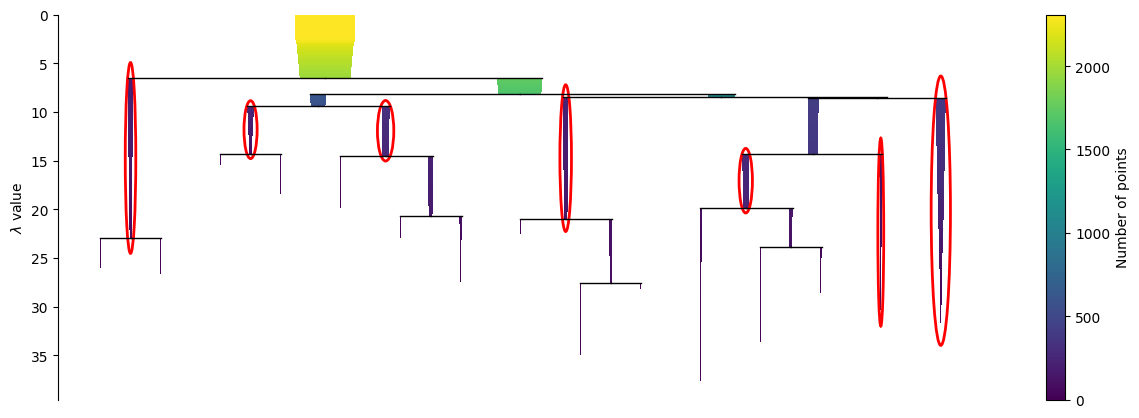

In [24]:
plt.figure(figsize=(15, 5))
hdbscan_clust.condensed_tree_.plot(select_clusters=True);

On insère de regroupement dans notre tableau, puis on compare tous nos algorithmes de partitionnement!

In [25]:
df_mcinnes = (
    df_mcinnes
    .with_columns(pl.Series(hdbscan_clust.labels_).alias('hdbscan_groups'))
)

df_mcinnes_tidy = (
    df_mcinnes
    .melt(id_vars=['X', 'Y'])
    .with_columns(pl.col('value').cast(pl.Utf8).cast(pl.Categorical))
)

(
    ggplot(data=df_mcinnes_tidy)
    + geom_point(mapping = aes(x = 'X', y = 'Y', color = 'value'))
    + facet_wrap(facets='variable', ncol=2)
)

Le *DBSCAN* fonctionne bien, mais j'ai dû ajuster les paramètres pour avoir une disposition visuelle conforme à mes attentes, ce qui est difficile avec des données multi-dimensionnelles. À l'image des *kmeans* Le partitionnement hiérarchique performe plutôt mal, mais il a l'avantage de pouvoir être investigué à l'aide d'un dendrogramme. Le *HDBSCAN*, quant à lui, fonctionne très bien sans avoir besoin d'être scrupuleusement paramétré.